# Import modules

In [1]:
import datetime
import itertools
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from tx_fast_hydrology.muskingum import Muskingum, ModelCollection, Connection
from tx_fast_hydrology.simulation import AsyncSimulation
from tx_fast_hydrology.da import KalmanFilter

# Load model collection

In [2]:
# Define model file input path
input_path = '../data/shoal_waller_less_densified_partitioned.json'
# Load model collection from file
model_collection = ModelCollection.from_file(input_path)

Text(0.5, 1.0, 'Sub-models')

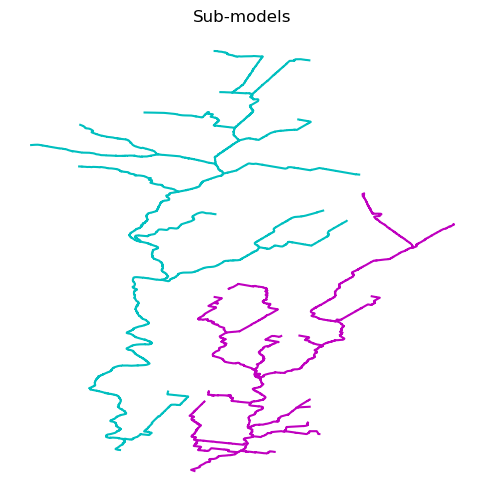

In [3]:
# Plot model collection with sub-models in different colors
fig, ax = plt.subplots(figsize=(6,6))
colors = dict(zip(model_collection.models.keys(), ['c', 'm', 'y', 'k']))
for model_name, model in model_collection.models.items():
    model.plot(ax=ax, c=colors[model_name])
plt.axis('off')
plt.title('Sub-models')

# Create model inputs

### Load NWM forcings

In [4]:
# Define path for NWM forcings
forcing_path = '../data/20240122_event'
# Required NWM variables
nwm_vars = ['qBucket', 'qSfcLatRunoff', 'streamflow']
# Date range to load
date_list = pd.date_range('20240121', '20240124', freq='h', tz='utc')[:-1]

# Loop through HDF5 files and load forcings into memory
streamflows = []
runoffs = []
buckets = []
for date in date_list:
    date_str = date.strftime('%Y%m%d%H')
    streamflow = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='no_data_assimilation__streamflow')
    runoff = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='no_data_assimilation__qSfcLatRunoff')
    bucket = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='no_data_assimilation__qBucket')
    streamflows.append(streamflow)
    runoffs.append(runoff)
    buckets.append(bucket)
# Concatenate all forcings into single dataframe
streamflow = pd.concat(streamflows)
runoff = pd.concat(runoffs)
bucket = pd.concat(buckets)
# Lateral inflow at each reach is equal to runoff plus bucket recharge
forcing = runoff + bucket

# Ensure no duplicate entries
forcing = forcing.groupby(level=0).mean()
streamflow = streamflow.groupby(level=0).mean()

# Format column types
forcing.columns = forcing.columns.astype(str)
streamflow.columns = forcing.columns.astype(str)

# Forecasting

In [5]:
def load_nwm_data(forcing_path, date):
    date_str = date.strftime('%Y%m%d%H')
    streamflow = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='short_range__streamflow')
    runoff = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='short_range__qSfcLatRunoff')
    bucket = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='short_range__qBucket')


    forcing = runoff + bucket
    return streamflow, forcing

In [6]:
all_outputs_da = {}
for date in date_list:
    date_str = date.strftime('%Y%m%d%H')
    model_collection.load_states()
    
    streamflow, forcing = load_nwm_data(forcing_path, date)
    forcing.columns = forcing.columns.astype(str)
    streamflow.columns = forcing.columns.astype(str)
    inputs = forcing

    input_columns = list(itertools.chain.from_iterable([model.reach_ids for model 
                                                    in model_collection.models.values()]))
    input_index = forcing.index.copy()
    inputs = pd.DataFrame(0., index=input_index, columns=input_columns)

    # Fill input table with forcings for each reach
    store = pd.HDFStore('../data/area_fractions_shoalwaller.h5', 'r')
    hdf_keys = store.keys()
    store.close()
    for key in hdf_keys:
        comid = key.split('__')[-1]
        area_ratios = pd.read_hdf(f'../data/area_fractions_shoalwaller.h5', key=key)
        for reach_id in area_ratios.index:
            if comid in forcing.columns:
                runoff_proportion = area_ratios.loc[reach_id].item() * forcing[comid]
                reach_id_str = str(reach_id)
                if reach_id_str in inputs.columns:
                    inputs[reach_id_str] += runoff_proportion

    inputs.columns = inputs.columns.astype(str)
    dt = model_collection.timedelta.seconds
    inputs = inputs.resample(f'{dt}s').mean()
    inputs = inputs.interpolate().bfill().ffill()
    
    for model in model_collection.models.values():
        outlet = model.startnodes[model.startnodes == model.endnodes].item()
        model.set_transmissive_boundary(outlet)

    timedelta = pd.to_timedelta(dt, unit='s')
    for model_name, model in model_collection.models.items():
        model.datetime = inputs.index[0] - pd.to_timedelta('1h')

    simulation = AsyncSimulation(model_collection, inputs)
    outputs = await simulation.simulate()
    all_outputs_da[date_str] = pd.concat([series for series in outputs.values()], axis=1)

In [7]:
date_str

'2024012323'

In [8]:
all_outputs_da[date_str]

,3578,3579,3580,3581,3594,3595,3596,3597,3598,3599,...,3677,3678,3694,3695,3696,3697,3698,3700,3705,3706
2024-01-23 23:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-01-23 23:00:20+00:00,0.000576,0.004232,0.000394,-0.000109,0.005003,-0.000442,0.004177,0.002523,0.002431,0.003064,...,0.000144,0.001763,0.001514,0.004783,-0.000842,0.000618,0.000230,0.000421,0.003868,0.003868
2024-01-23 23:00:40+00:00,0.000982,0.008692,0.000878,-0.000138,0.009664,-0.000413,0.007902,0.004892,0.004913,0.005881,...,0.000478,0.003337,0.002937,0.009395,-0.001295,0.001181,0.000510,0.000806,0.007195,0.007195
2024-01-23 23:01:00+00:00,0.001270,0.013193,0.001506,0.000024,0.014004,0.000027,0.011255,0.007116,0.007431,0.008471,...,0.000927,0.004776,0.004274,0.013839,-0.001392,0.001692,0.000829,0.001157,0.010222,0.010222
2024-01-23 23:01:20+00:00,0.001473,0.017616,0.002314,0.000446,0.018046,0.000820,0.014306,0.009204,0.009970,0.010853,...,0.001441,0.006114,0.005530,0.018120,-0.001168,0.002158,0.001179,0.001477,0.013088,0.013088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-24 16:58:40+00:00,0.000938,0.087621,0.290740,0.536750,0.035293,0.043030,0.072614,0.019963,0.045052,0.018868,...,0.006521,0.019799,0.014428,0.066524,0.072048,0.004167,0.006886,0.002790,0.818312,0.818312
2024-01-24 16:59:00+00:00,0.000937,0.087513,0.290383,0.536101,0.035253,0.042981,0.072526,0.019936,0.044991,0.018844,...,0.006520,0.019800,0.014429,0.066531,0.072055,0.004167,0.006887,0.002790,0.818309,0.818309
2024-01-24 16:59:20+00:00,0.000935,0.087406,0.290027,0.535452,0.035214,0.042932,0.072438,0.019909,0.044931,0.018819,...,0.006519,0.019801,0.014431,0.066538,0.072062,0.004168,0.006888,0.002791,0.818307,0.818307
2024-01-24 16:59:40+00:00,0.000934,0.087298,0.289671,0.534803,0.035174,0.042883,0.072350,0.019882,0.044871,0.018794,...,0.006519,0.019802,0.014433,0.066544,0.072070,0.004168,0.006888,0.002791,0.818306,0.818306


In [15]:
all_outputs_da 

{'2024012100':                                    3578          3579          3580  \
 2024-01-21 00:00:00+00:00  8.049873e-18 -1.032198e-17  7.751666e-16   
 2024-01-21 00:00:20+00:00  5.633003e-05  4.033831e-04  3.877003e-05   
 2024-01-21 00:00:40+00:00  9.612271e-05  8.296426e-04  8.607921e-05   
 2024-01-21 00:01:00+00:00  1.242331e-04  1.261296e-03  1.472381e-04   
 2024-01-21 00:01:20+00:00  1.440908e-04  1.686831e-03  2.260720e-04   
 ...                                 ...           ...           ...   
 2024-01-21 17:58:40+00:00  1.796767e-04  1.496464e-02  5.001047e-02   
 2024-01-21 17:59:00+00:00  1.796764e-04  1.496242e-02  5.000854e-02   
 2024-01-21 17:59:20+00:00  1.796761e-04  1.496021e-02  5.000661e-02   
 2024-01-21 17:59:40+00:00  1.796758e-04  1.495799e-02  5.000467e-02   
 2024-01-21 18:00:00+00:00  1.796755e-04  1.495577e-02  5.000272e-02   
 
                                    3581          3594          3595  \
 2024-01-21 00:00:00+00:00 -4.311918e-14  2.2936

In [9]:
site = '3701'

site_output_da = {}
for date in date_list:
    date_str = date.strftime('%Y%m%d%H')
    site_output_da[date] = all_outputs_da[date_str][site]

In [15]:
all_outputs_da[date_str][site]

2024-01-21 23:00:00+00:00     0.000003
2024-01-21 23:00:20+00:00     0.000325
2024-01-21 23:00:40+00:00     0.000664
2024-01-21 23:01:00+00:00     0.001018
2024-01-21 23:01:20+00:00     0.001383
                               ...    
2024-01-22 16:58:40+00:00    24.379050
2024-01-22 16:59:00+00:00    24.397466
2024-01-22 16:59:20+00:00    24.415393
2024-01-22 16:59:40+00:00    24.432830
2024-01-22 17:00:00+00:00    24.449772
Name: 3701, Length: 3241, dtype: float64

In [18]:
site_output_da.keys()

dict_keys([Timestamp('2024-01-21 00:00:00+0000', tz='UTC'), Timestamp('2024-01-21 01:00:00+0000', tz='UTC'), Timestamp('2024-01-21 02:00:00+0000', tz='UTC'), Timestamp('2024-01-21 03:00:00+0000', tz='UTC'), Timestamp('2024-01-21 04:00:00+0000', tz='UTC'), Timestamp('2024-01-21 05:00:00+0000', tz='UTC'), Timestamp('2024-01-21 06:00:00+0000', tz='UTC'), Timestamp('2024-01-21 07:00:00+0000', tz='UTC'), Timestamp('2024-01-21 08:00:00+0000', tz='UTC'), Timestamp('2024-01-21 09:00:00+0000', tz='UTC'), Timestamp('2024-01-21 10:00:00+0000', tz='UTC'), Timestamp('2024-01-21 11:00:00+0000', tz='UTC'), Timestamp('2024-01-21 12:00:00+0000', tz='UTC'), Timestamp('2024-01-21 13:00:00+0000', tz='UTC'), Timestamp('2024-01-21 14:00:00+0000', tz='UTC'), Timestamp('2024-01-21 15:00:00+0000', tz='UTC'), Timestamp('2024-01-21 16:00:00+0000', tz='UTC'), Timestamp('2024-01-21 17:00:00+0000', tz='UTC'), Timestamp('2024-01-21 18:00:00+0000', tz='UTC'), Timestamp('2024-01-21 19:00:00+0000', tz='UTC'), Timestamp

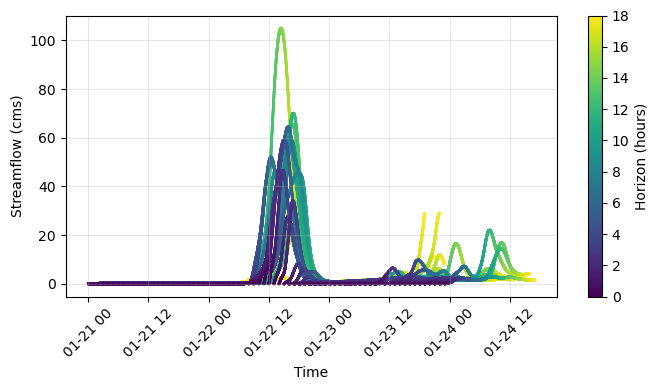

In [10]:
fig, ax = plt.subplots(figsize=(7, 4))

max_horizon = 0
for forecast_time, forecast_series in site_output_da.items():
    horizons = [(target_time - forecast_time).total_seconds() / 3600 
               for target_time in forecast_series.index]
    max_horizon = max(max_horizon, max(horizons))

all_target_times = []
all_values = []
all_horizons = []

for forecast_time, forecast_series in list(site_output_da.items()):
    horizons = [(target_time - forecast_time).total_seconds() / 3600 
               for target_time in forecast_series.index]
    
    all_target_times.extend(forecast_series.index)
    all_values.extend(forecast_series.values)
    all_horizons.extend(horizons)

scatter = ax.scatter(all_target_times, all_values, 
                    c=all_horizons, cmap='viridis', s=1, alpha=1,
                    vmin=0, vmax=max_horizon)

plt.colorbar(scatter, ax=ax, label='Horizon (hours)')
ax.set_xlabel('Time')
ax.set_ylabel('Streamflow (cms)')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Time-lagged ensemble mean

In [15]:
da_spreads = {}
da_spread = pd.concat((value for value in site_output_da.values()), axis=1)
da_spreads = da_spread

In [16]:
def mean_first_12_hours(row): # 6 hours
    valid_values = row.dropna()[:-6]#[-12:-2]#[-19:-12] 3240 -6 correspond to forecasting 12 hours ahead
    return valid_values.mean()

In [17]:
timelagged_da = da_spreads.apply(mean_first_12_hours, axis=1) # drop nan along columns

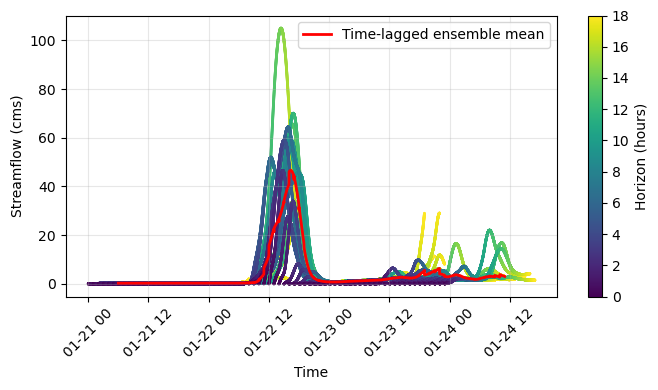

In [18]:
fig, ax = plt.subplots(figsize=(7, 4))

max_horizon = 0
for forecast_time, forecast_series in site_output_da.items():
    horizons = [(target_time - forecast_time).total_seconds() / 3600 
               for target_time in forecast_series.index]
    max_horizon = max(max_horizon, max(horizons))

all_target_times = []
all_values = []
all_horizons = []

for forecast_time, forecast_series in list(site_output_da.items()):
    horizons = [(target_time - forecast_time).total_seconds() / 3600 
               for target_time in forecast_series.index]
    
    all_target_times.extend(forecast_series.index)
    all_values.extend(forecast_series.values)
    all_horizons.extend(horizons)

scatter = ax.scatter(all_target_times, all_values, 
                    c=all_horizons, cmap='viridis', s=1, alpha=1,
                    vmin=0, vmax=max_horizon)
plt.plot(timelagged_da.index, timelagged_da.values, color='red', linewidth=2, label='Time-lagged ensemble mean')
plt.colorbar(scatter, ax=ax, label='Horizon (hours)')
ax.set_xlabel('Time')
ax.set_ylabel('Streamflow (cms)')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()